In [9]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re


### fixed variables
VOLUME_PER_IMAGE = 50 * (3.5)**2 * np.pi  # in cubic centimeters
VOLUME_PER_IMAGE_LITERS = VOLUME_PER_IMAGE / 1000  # convert to liters
IMAGE_SIZE = 2560

In [10]:
top6_validated_df = pd.read_csv("C:/Users/fanny/OneDrive - Van Hall Larenstein/HVHL/Year_IV/Thesis_Internship/ET_data/top6_biovolume_groups_validated_only.csv")

all_images_df = pd.read_csv("C:/Users/fanny/OneDrive - Van Hall Larenstein/HVHL/Year_IV/Thesis_Internship/ET_data/M181_all_images_metadata.csv")

C:\Users\fanny\AppData\Local\Temp\ipykernel_14228\1831068691.py:1: DtypeWarning: Columns (0,51,62,63,70,74,75,76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  top6_validated_df = pd.read_csv("C:/Users/fanny/OneDrive - Van Hall Larenstein/HVHL/Year_IV/Thesis_Internship/ET_data/top6_biovolume_groups_validated_only.csv")


Using 5 filtered image profiles for volume calculation


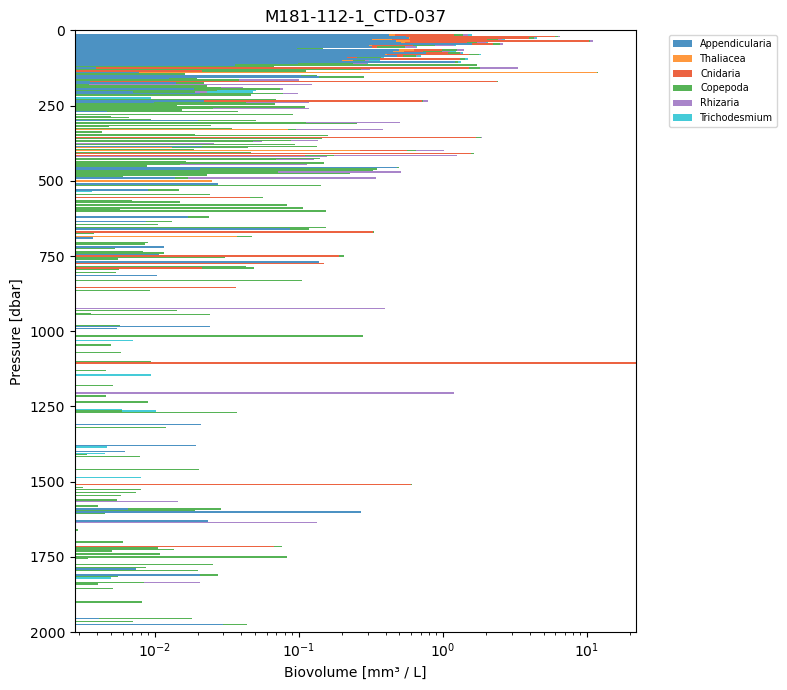

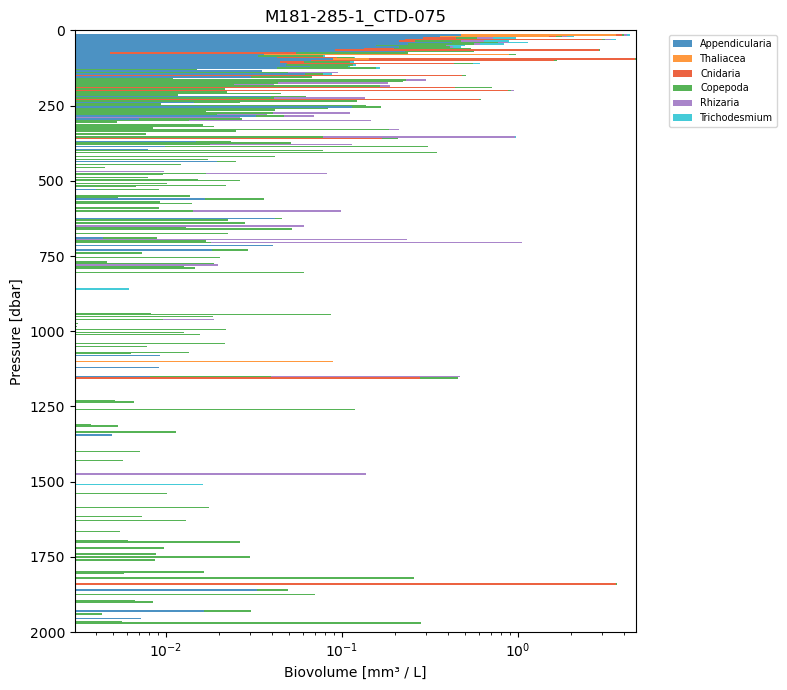

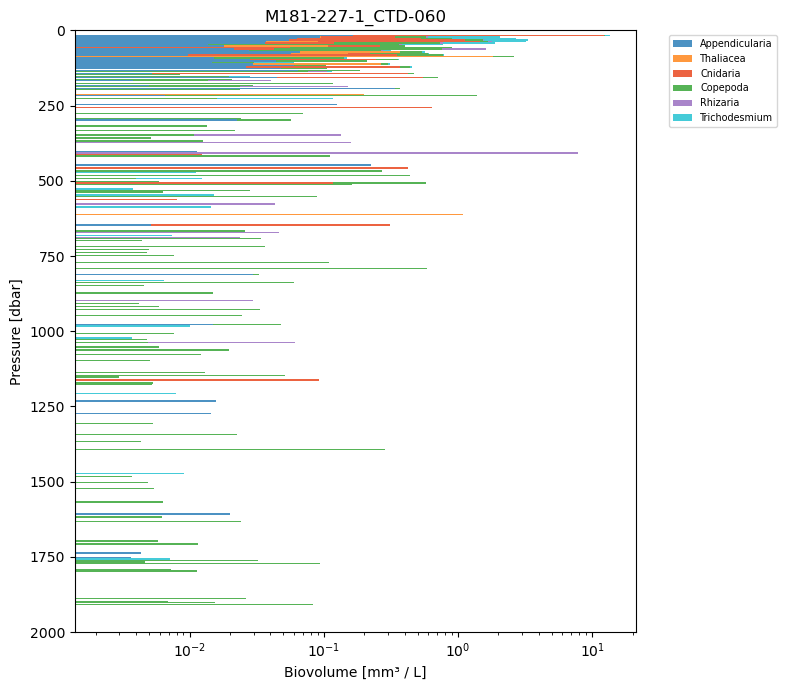

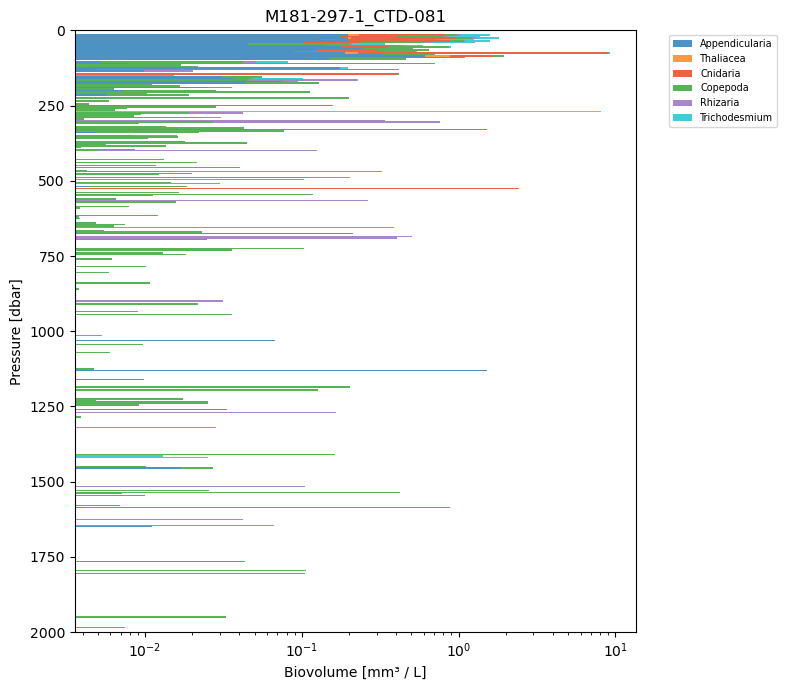

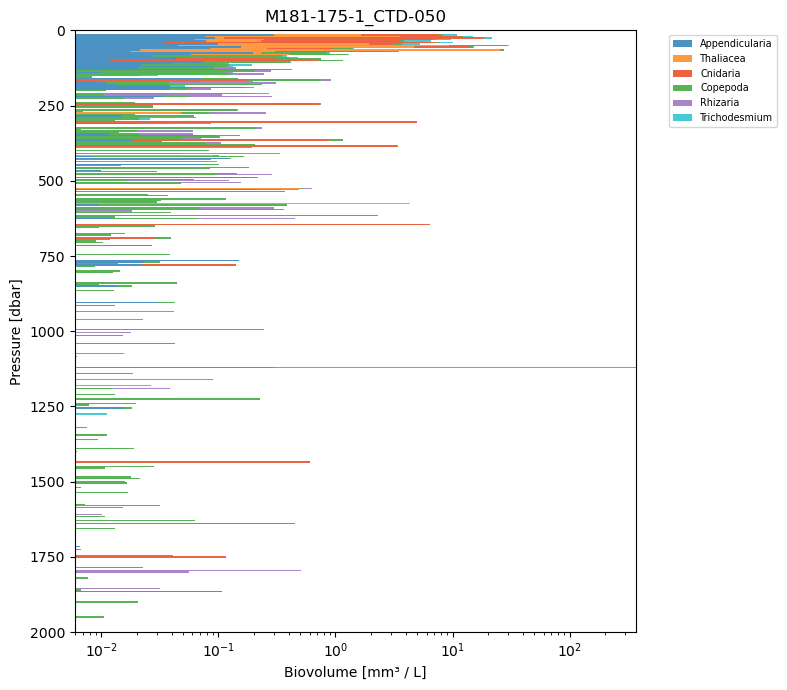

In [11]:
def plot_total_biovolume_vs_pressure_stacked_individual(df, all_images_df, depth_bin_size=20, max_depth=2000, plot_path=None):

    main_groups = [
        "Appendicularia", "Thaliacea",
        "Cnidaria", "Copepoda",
        "Rhizaria", "Trichodesmium"
    ]
    group_colors = [
        "#1f77b4", "#ff7f0e", "#e83c12", "#2ca02c", "#9467bd", "#17becf"
    ]
    color_dict = dict(zip(main_groups, group_colors))

    # CORRECTED: Filter images to only matching CTD numbers from organism profiles
    def extract_ctd_number(sample_id):
        import re
        match = re.search(r'CTD-(\d+)', str(sample_id))
        if match:
            return match.group(1).zfill(3)  # Pad to 3 digits
        return None

    # Get CTD numbers from organism profiles
    organism_profiles = sorted(df['sample_id'].unique())
    organism_ctd_numbers = set()
    for profile in organism_profiles:
        ctd_num = extract_ctd_number(profile)
        if ctd_num:
            organism_ctd_numbers.add(ctd_num)

    # Filter images to only matching CTD numbers
    matching_image_profiles = []
    for img_profile in all_images_df['sample_id'].unique():
        img_ctd_num = extract_ctd_number(img_profile)
        if img_ctd_num and img_ctd_num in organism_ctd_numbers:
            matching_image_profiles.append(img_profile)

    print(f"Using {len(matching_image_profiles)} filtered image profiles for volume calculation")
    
    # Use only filtered images for all volume calculations
    filtered_images_df = all_images_df[all_images_df['sample_id'].isin(matching_image_profiles)]

    profiles = list(df['sample_id'].unique())

    for profile_name in profiles:
        profile_df = df[df['sample_id'] == profile_name].copy()
        profile_df['object_pressure'] = pd.to_numeric(profile_df['object_pressure'], errors='coerce')
        profile_df['object_esd'] = pd.to_numeric(profile_df['object_esd'], errors='coerce')
        profile_df = profile_df.dropna(subset=['object_pressure', 'object_esd'])
        if not profile_df.empty:
            # ensure both µm³ and mm³ volume columns are present (mm³ = µm³ / 1e9)
            if 'volume_um3' not in profile_df.columns:
                profile_df['volume_um3'] = (4/3) * np.pi * (profile_df['object_esd']/2)**3
                profile_df['volume_mm3'] = profile_df['volume_um3'] / 1e9

            min_p = profile_df['object_pressure'].min()
            max_p = min(max_depth, profile_df['object_pressure'].max())
            pressure_bins = np.arange(min_p, max_p + depth_bin_size, depth_bin_size)
            profile_df['pressure_bin'] = np.digitize(profile_df['object_pressure'], pressure_bins)

            core_id = profile_name.split('_')[0] + '_' + profile_name.split('_')[1]
            # CORRECTED: Use filtered images instead of all images
            images_for_profile = filtered_images_df[filtered_images_df['sample_id'] == core_id].copy()
            images_for_profile['pressure_bin'] = np.digitize(images_for_profile['pressure'], pressure_bins)
            images_per_bin = images_for_profile.groupby('pressure_bin').size().reindex(range(1, len(pressure_bins)), fill_value=0)
            sampled_volume_L = images_per_bin * VOLUME_PER_IMAGE_LITERS

            # Prepare stacked data for each group (use mm³ directly when available)
            stacked_data = []
            for group in main_groups:
                if 'volume_mm3' in profile_df.columns:
                    group_bin_sum_mm3 = profile_df[profile_df['object_annotation_category'] == group].groupby('pressure_bin')['volume_mm3'].sum().reindex(range(1, len(pressure_bins)), fill_value=0)
                else:
                    group_bin_sum = profile_df[profile_df['object_annotation_category'] == group].groupby('pressure_bin')['volume_um3'].sum().reindex(range(1, len(pressure_bins)), fill_value=0)
                    group_bin_sum_mm3 = group_bin_sum / 1e9
                # normalize per sampled volume in liters -> mm³ / L
                group_norm = group_bin_sum_mm3 / sampled_volume_L.replace(0, np.nan)
                stacked_data.append(group_norm.values)

            # Create a new figure for each profile
            fig, ax = plt.subplots(figsize=(8, 7))
            bottom = np.zeros(len(pressure_bins)-1)
            for idx, group in enumerate(main_groups):
                values = stacked_data[idx]
                ax.barh(pressure_bins[1:], values, left=bottom, height=depth_bin_size*0.9, color=color_dict[group], label=group, alpha=0.8)
                bottom += np.nan_to_num(values)

            ax.set_xscale('log')
            ax.invert_yaxis()
            ax.set_title(f"{profile_name[:18]}")
            ax.set_ylim(top=0, bottom=max_depth)
            ax.set_xlabel('Biovolume [mm³ / L]')
            ax.set_ylabel('Pressure [dbar]')
            ax.legend(fontsize='x-small', bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.tight_layout()
            if plot_path:
                filename = f"total_biovolume_vs_pressure_stacked_{profile_name[:18]}.png"
                plt.savefig(os.path.join(plot_path, filename), dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()


plot_total_biovolume_vs_pressure_stacked_individual(
    top6_validated_df, all_images_df,
    depth_bin_size=5, max_depth=2000,
    plot_path='C:/Users/fanny/OneDrive - Van Hall Larenstein/HVHL/Year_IV/Thesis_Internship/plots'
)

In [12]:
def plot_stacked_classes_per_profile(src_df,
                                      sampled_vol=None,
                                      value_col='volume_um3',
                                      normalize=True,
                                      convert_to_mm3=True,
                                      top_n=None,
                                      order_profiles=None,
                                      plot_path=None,
                                      figsize=(12,4)):

    # aggregate to profile × class
    agg = src_df.groupby(['sample_id','object_annotation_category'])[value_col].sum().unstack(fill_value=0)

    # optionally keep only top_n classes and group others
    if top_n is not None and top_n < agg.shape[1]:
        totals = agg.sum(axis=0).sort_values(ascending=False)
        top_cols = totals.index[:top_n].tolist()
        other_cols = [c for c in agg.columns if c not in top_cols]
        if other_cols:
            agg['Other'] = agg[other_cols].sum(axis=1)
        agg = agg[top_cols + (['Other'] if other_cols else [])]

    # normalize per L if requested
    if normalize:
        if sampled_vol is None:
            raise ValueError('sampled_vol must be provided when normalize=True')
        sv = sampled_vol.set_index('sample_id')['sampled_volume_L']
        agg = agg.div(sv.replace(0, np.nan), axis=0)

    # convert μm³ → mm³ if requested
    unit_label = ''
    if convert_to_mm3 and value_col.lower().find('volume') >= 0:
        agg = agg / 1e9
        unit_label = 'mm³'
    elif value_col.lower().find('volume') >= 0:
        unit_label = 'μm³'
    # if plotting counts, set counts unit (counts_per_L expected to already be per L when passed)
    if 'count' in value_col.lower():
        unit_label = '# / L'
    if normalize and unit_label and unit_label != '# / L':
        unit_label = f'{unit_label} L⁻¹'

    # order profiles
    if order_profiles is None:
        profiles = sorted(agg.index.tolist())
    else:
        profiles = [p for p in order_profiles if p in agg.index] + [p for p in sorted(agg.index) if p not in (order_profiles or [])]
    agg = agg.reindex(profiles).fillna(0)

    # --- use same groups/colors and category ordering as counts plot ---
    main_groups = ["Appendicularia", "Thaliacea", "Cnidaria", "Copepoda", "Rhizaria", "Trichodesmium"]
    group_colors = ["#1f77b4", "#ff7f0e", "#e83c12", "#2ca02c", "#9467bd", "#17becf"]
    group_color_map = dict(zip(main_groups, group_colors))

    # enforce category order: main_groups first if present, then any remaining columns
    cats = [c for c in main_groups if c in agg.columns] + [c for c in agg.columns if c not in main_groups]
    agg = agg.reindex(columns=cats).fillna(0)

    # prepare colors in same order as categories
    cmap = plt.get_cmap('tab20')
    colors_list = [group_color_map.get(cat, cmap(i % cmap.N)) for i, cat in enumerate(cats)]

    # plotting: use same sizing rule as counts plot
    fig, ax = plt.subplots(figsize=(max(8, len(agg.index)*0.4), 5))
    x = np.arange(len(agg))
    bottom = np.zeros(len(agg))
    for i, cat in enumerate(cats):
        vals = agg[cat].values
        ax.bar(x, vals, bottom=bottom, color=colors_list[i], label=cat, width=0.7)
        bottom += vals

    # CTD label extractor that reads the CTD-### token from sample_id
    def _ctd_label_from_sample_id(p):
        s = str(p)
        m = re.search(r'CTD-(\d{1,})', s)
        if m:
            return f"CTD-{int(m.group(1)):03d}"
        parts = s.split('_')
        for tok in parts:
            if tok.isdigit() and len(tok) == 3:
                return f"CTD-{int(tok):03d}"
        for tok in parts:
            if tok.isdigit() and 1 <= len(tok) <= 3:
                return f"CTD-{int(tok):03d}"
        m_all = re.findall(r'(\d{1,3})', s)
        if m_all:
            return f"CTD-{int(m_all[-1]):03d}"
        return s

    labels = [_ctd_label_from_sample_id(p) for p in agg.index]

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    # choose appropriate ylabel depending on whether we're plotting counts or biovolume
    if 'count' in value_col.lower():
        ax.set_ylabel(f'Counts [{unit_label}]')
    elif value_col.lower().find('volume') >= 0:
        ax.set_ylabel(f'Biovolume [{unit_label}]' if unit_label else 'Biovolume')
    else:
        ax.set_ylabel('Value')

    ax.set_title('Stacked classes per profile')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
    plt.tight_layout(rect=[0,0,0.78,1])

    if plot_path:
        os.makedirs(plot_path, exist_ok=True)
        fig.savefig(os.path.join(plot_path, 'stacked_classes_per_profile.png'), dpi=300, bbox_inches='tight')

    plt.show()
    return fig, ax, agg

Organism profiles and extracted CTD numbers:
  M181-112-1_CTD-037_00°00S-008°00W_20220504-1758 -> CTD-037
  M181-175-1_CTD-050_00°00S-019°00W_20220509-0543 -> CTD-050
  M181-227-1_CTD-060_00°00S-027°00W_20220512-1748 -> CTD-060
  M181-285-1_CTD-075_00°00S-039°00W_20220517-2024 -> CTD-075
  M181-297-1_CTD-081_00°00S-041°50W_20220519-0218 -> CTD-081

Unique CTD numbers from organisms: [37, 50, 60, 75, 81]

Image profiles and CTD matching:
  SKIPPED: M181-107-1_CTD-036 -> CTD-036
  MATCHED: M181-112-1_CTD-037 -> CTD-037
  SKIPPED: M181-117-1_CTD-038 -> CTD-038
  SKIPPED: M181-124-1_CTD-039 -> CTD-039
  SKIPPED: M181-126-1_CTD-040 -> CTD-040
  SKIPPED: M181-131-1_CTD-041 -> CTD-041
  SKIPPED: M181-134-1_CTD-042 -> CTD-042
  SKIPPED: M181-140-1_CTD-043 -> CTD-043
  SKIPPED: M181-146-1_CTD-044 -> CTD-044
  SKIPPED: M181-153-1_CTD-045 -> CTD-045
  SKIPPED: M181-156-1_CTD-046 -> CTD-046
  SKIPPED: M181-160-1_CTD-047 -> CTD-047
  SKIPPED: M181-165-1_CTD-048 -> CTD-048
  SKIPPED: M181-170-1_CTD-

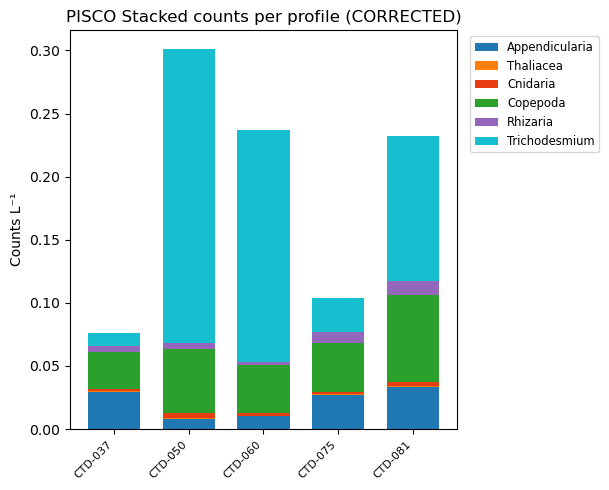

In [14]:
# Build and plot counts (counts per L) using FILTERED images only

# define same groups/colors as used earlier
main_groups = ["Appendicularia", "Thaliacea", "Cnidaria", "Copepoda", "Rhizaria", "Trichodesmium"]
group_colors = ["#1f77b4", "#ff7f0e", "#e83c12", "#2ca02c", "#9467bd", "#17becf"]
group_color_map = dict(zip(main_groups, group_colors))

# prepare prof_counts
if 'top6_validated_df' not in globals():
    raise ValueError('top6_validated_df not found')
tmp = top6_validated_df.copy()
tmp['object_annotation_category'] = tmp['object_annotation_category'].astype(str)

# counts per profile × class
prof_counts = tmp.groupby(['sample_id','object_annotation_category']).size().reset_index(name='count')

# IMPROVED: Better CTD number extraction with debugging
def extract_ctd_number(sample_id):
    import re
    # First try the CTD-### pattern
    match = re.search(r'CTD-(\d+)', str(sample_id))
    if match:
        return int(match.group(1))  # Return as integer for proper comparison
    return None

# Get CTD numbers from organism profiles with debugging
organism_profiles = sorted(tmp['sample_id'].unique())
organism_ctd_numbers = set()
print("Organism profiles and extracted CTD numbers:")
for profile in organism_profiles:
    ctd_num = extract_ctd_number(profile)
    if ctd_num:
        organism_ctd_numbers.add(ctd_num)
        print(f"  {profile} -> CTD-{ctd_num:03d}")
    else:
        print(f"  {profile} -> No CTD number found")

print(f"\nUnique CTD numbers from organisms: {sorted(organism_ctd_numbers)}")

# Filter images to only matching CTD numbers with debugging
matching_image_profiles = []
print("\nImage profiles and CTD matching:")
for img_profile in sorted(all_images_df['sample_id'].unique()):
    img_ctd_num = extract_ctd_number(img_profile)
    if img_ctd_num and img_ctd_num in organism_ctd_numbers:
        matching_image_profiles.append(img_profile)
        print(f"  MATCHED: {img_profile} -> CTD-{img_ctd_num:03d}")
    else:
        # Fixed: Separate conditional logic from format specifier
        ctd_display = f"CTD-{img_ctd_num:03d}" if img_ctd_num else "None"
        print(f"  SKIPPED: {img_profile} -> {ctd_display}")

print(f"\nFINAL: Using {len(matching_image_profiles)} filtered image profiles (from {all_images_df['sample_id'].nunique()} total)")
print(f"Matching image profiles: {sorted(matching_image_profiles)}")

# Use only filtered images for volume calculation
filtered_images_df = all_images_df[all_images_df['sample_id'].isin(matching_image_profiles)]
images_counts = filtered_images_df.groupby('sample_id').size().to_dict()

print(f"\nImage counts per profile:")
for profile, count in sorted(images_counts.items()):
    print(f"  {profile}: {count} images")

# ...existing code for sampled_vol_local calculation...
profiles = sorted(prof_counts['sample_id'].unique())
sampled_records = []
for p in profiles:
    parts = str(p).split('_')
    core_id = f"{parts[0]}_{parts[1]}" if len(parts) >= 2 else parts[0]
    nimg = int(images_counts.get(core_id, 0))
    sampled_records.append({'sample_id': p, 'sampled_volume_L': nimg * VOLUME_PER_IMAGE_LITERS})
    print(f"Profile {p} -> core_id {core_id} -> {nimg} images -> {nimg * VOLUME_PER_IMAGE_LITERS:.4f} L")

sampled_vol_local = pd.DataFrame(sampled_records)

# merge counts with sampled volume and compute counts_per_L
prof_counts = prof_counts.merge(sampled_vol_local, on='sample_id', how='left')
prof_counts['counts_per_L'] = prof_counts['count'] / prof_counts['sampled_volume_L'].replace({0: np.nan})

# pivot to wide form (profiles × classes)
agg_counts = prof_counts.pivot(index='sample_id', columns='object_annotation_category', values='counts_per_L').fillna(0)

# ensure same profile order as biovolume plot
order_profiles = sorted(agg_counts.index.tolist())
agg_counts = agg_counts.reindex(order_profiles).fillna(0)

# determine categories order (keep main_groups order first, then any others)
cats = [c for c in main_groups if c in agg_counts.columns] + [c for c in agg_counts.columns if c not in main_groups]
agg_counts = agg_counts.reindex(columns=cats).fillna(0)

# build colors list matching categories
cmap = plt.get_cmap('tab20')
colors = [group_color_map.get(cat, cmap(i % cmap.N)) for i, cat in enumerate(cats)]

# plot stacked counts per profile
fig, ax = plt.subplots(figsize=(max(8, len(order_profiles)*0.4), 5))
x = np.arange(len(agg_counts))
bottom = np.zeros(len(agg_counts))
for i, cat in enumerate(cats):
    vals = agg_counts[cat].values
    ax.bar(x, vals, bottom=bottom, color=colors[i], label=cat, width=0.7)
    bottom += vals

# use same CTD extraction from sample_id for counts plot
def _ctd_label_from_sample_id(p):
    s = str(p)
    m = re.search(r'CTD-(\d{1,})', s)
    if m:
        return f"CTD-{int(m.group(1)):03d}"
    parts = s.split('_')
    for tok in parts:
        if tok.isdigit() and len(tok) == 3:
            return f"CTD-{int(tok):03d}"
    for tok in parts:
        if tok.isdigit() and 1 <= len(tok) <= 3:
            return f"CTD-{int(tok):03d}"
    m_all = re.findall(r'(\d{1,3})', s)
    if m_all:
        return f"CTD-{int(m_all[-1]):03d}"
    return s

labels = [_ctd_label_from_sample_id(p) for p in agg_counts.index]

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Counts L⁻¹')
ax.set_title('PISCO Stacked counts per profile (CORRECTED)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
plt.tight_layout(rect=[0,0,0.78,1])

if 'plot_path' in globals() and plot_path:
    os.makedirs(plot_path, exist_ok=True)
    fname = os.path.join(plot_path, 'stacked_counts_per_profile_corrected.png')
    fig.savefig(fname, dpi=300, bbox_inches='tight')
    print(f"Saved corrected counts plot to: {fname}")

plt.show()
plt.close()

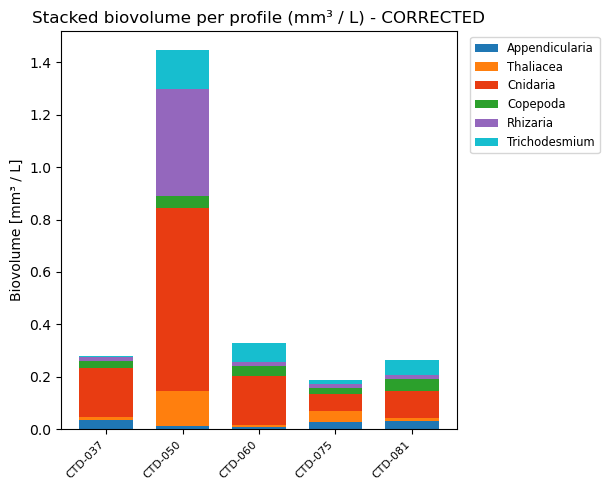

In [ ]:
# CORRECTED: Build and plot biovolume (mm³ / L) using FILTERED images only

# define same groups/colors as used earlier
main_groups = ["Appendicularia", "Thaliacea", "Cnidaria", "Copepoda", "Rhizaria", "Trichodesmium"]
group_colors = ["#1f77b4", "#ff7f0e", "#e83c12", "#2ca02c", "#9467bd", "#17becf"]
group_color_map = dict(zip(main_groups, group_colors))

# prepare data from top6_validated_df
if 'top6_validated_df' not in globals():
    raise ValueError('top6_validated_df not found')
tmp = top6_validated_df.copy()
tmp['object_annotation_category'] = tmp['object_annotation_category'].astype(str)

# ensure volume_um3 and volume_mm3 exist
if 'volume_um3' not in tmp.columns:
    tmp['object_esd'] = pd.to_numeric(tmp['object_esd'], errors='coerce')
    tmp['volume_um3'] = (4/3) * np.pi * (tmp['object_esd']/2.0)**3
    tmp['volume_mm3'] = tmp['volume_um3'] / 1e9

# biovolume sum per profile × class (use mm³ directly)
prof_biov = tmp.groupby(['sample_id','object_annotation_category'])['volume_mm3'].sum().reset_index(name='volume_mm3')

# CORRECTED: Use same filtered images approach as counts
def extract_ctd_number(sample_id):
    import re
    match = re.search(r'CTD-(\d+)', str(sample_id))
    if match:
        return match.group(1).zfill(3)  # Pad to 3 digits
    return None

# Get CTD numbers from organism profiles
organism_profiles = sorted(tmp['sample_id'].unique())
organism_ctd_numbers = set()
for profile in organism_profiles:
    ctd_num = extract_ctd_number(profile)
    if ctd_num:
        organism_ctd_numbers.add(ctd_num)

# Filter images to only matching CTD numbers
matching_image_profiles = []
for img_profile in all_images_df['sample_id'].unique():
    img_ctd_num = extract_ctd_number(img_profile)
    if img_ctd_num and img_ctd_num in organism_ctd_numbers:
        matching_image_profiles.append(img_profile)

# Use only filtered images for volume calculation
filtered_images_df = all_images_df[all_images_df['sample_id'].isin(matching_image_profiles)]
images_counts = filtered_images_df.groupby('sample_id').size().to_dict()

profiles = sorted(prof_biov['sample_id'].unique())
sampled_records = []
for p in profiles:
    parts = str(p).split('_')
    core_id = f"{parts[0]}_{parts[1]}" if len(parts) >= 2 else parts[0]
    nimg = int(images_counts.get(core_id, 0))
    sampled_records.append({'sample_id': p, 'sampled_volume_L': nimg * VOLUME_PER_IMAGE_LITERS})
sampled_vol_local = pd.DataFrame(sampled_records)

# merge and compute biovolume in mm³ per L
prof_biov = prof_biov.merge(sampled_vol_local, on='sample_id', how='left')
prof_biov['biovolume_mm3_per_L'] = prof_biov['volume_mm3'] / prof_biov['sampled_volume_L'].replace({0: np.nan})

# pivot to wide form (profiles × classes)
agg_biov = prof_biov.pivot(index='sample_id', columns='object_annotation_category', values='biovolume_mm3_per_L').fillna(0)

# ensure same profile order as other plots
order_profiles = sorted(agg_biov.index.tolist())
agg_biov = agg_biov.reindex(order_profiles).fillna(0)

# determine categories order (keep main_groups order first, then any others)
cats = [c for c in main_groups if c in agg_biov.columns] + [c for c in agg_biov.columns if c not in main_groups]
agg_biov = agg_biov.reindex(columns=cats).fillna(0)

# build colors list matching categories
cmap = plt.get_cmap('tab20')
colors = [group_color_map.get(cat, cmap(i % cmap.N)) for i, cat in enumerate(cats)]

# plot stacked biovolume per profile
fig, ax = plt.subplots(figsize=(max(8, len(order_profiles)*0.4), 5))
x = np.arange(len(agg_biov))
bottom = np.zeros(len(agg_biov))
for i, cat in enumerate(cats):
    vals = agg_biov[cat].values
    ax.bar(x, vals, bottom=bottom, color=colors[i], label=cat, width=0.7)
    bottom += vals

# CTD-style label extractor (same as used elsewhere)
def _ctd_label_from_sample_id(p):
    s = str(p)
    m = re.search(r'CTD-(\d{1,})', s)
    if m:
        return f"CTD-{int(m.group(1)):03d}"
    parts = s.split('_')
    for tok in parts:
        if tok.isdigit() and len(tok) == 3:
            return f"CTD-{int(tok):03d}"
    for tok in parts:
        if tok.isdigit() and 1 <= len(tok) <= 3:
            return f"CTD-{int(tok):03d}"
    m_all = re.findall(r'(\d{1,3})', s)
    if m_all:
        return f"CTD-{int(m_all[-1]):03d}"
    return s

labels = [_ctd_label_from_sample_id(p) for p in agg_biov.index]

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Biovolume [mm³ / L]')
ax.set_title('Stacked biovolume per profile (mm³ / L) - CORRECTED')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
plt.tight_layout(rect=[0,0,0.78,1])

if 'plot_path' in globals() and plot_path:
    os.makedirs(plot_path, exist_ok=True)
    fname = os.path.join(plot_path, 'stacked_biovolume_per_profile_corrected.png')
    fig.savefig(fname, dpi=300, bbox_inches='tight')
    print(f"Saved corrected biovolume plot to: {fname}")

plt.show()
plt.close()

In [ ]:
top6_validated_df['sample_id'].unique()

array(['M181-112-1_CTD-037_00°00S-008°00W_20220504-1758',
       'M181-285-1_CTD-075_00°00S-039°00W_20220517-2024',
       'M181-227-1_CTD-060_00°00S-027°00W_20220512-1748',
       'M181-297-1_CTD-081_00°00S-041°50W_20220519-0218',
       'M181-175-1_CTD-050_00°00S-019°00W_20220509-0543'], dtype=object)

In [ ]:
def build_class_summary(src_df, all_images_df, volume_per_image_liters=VOLUME_PER_IMAGE_LITERS, save_path=None):
    """
    CORRECTED: Return a summary DataFrame using only filtered images from matching CTD profiles
    """
    # CORRECTED: Filter images to only matching CTD numbers
    def extract_ctd_number(sample_id):
        import re
        match = re.search(r'CTD-(\d+)', str(sample_id))
        if match:
            return match.group(1).zfill(3)  # Pad to 3 digits
        return None

    # Get CTD numbers from organism profiles
    organism_profiles = sorted(src_df['sample_id'].unique())
    organism_ctd_numbers = set()
    for profile in organism_profiles:
        ctd_num = extract_ctd_number(profile)
        if ctd_num:
            organism_ctd_numbers.add(ctd_num)

    # Filter images to only matching CTD numbers
    matching_image_profiles = []
    for img_profile in all_images_df['sample_id'].unique():
        img_ctd_num = extract_ctd_number(img_profile)
        if img_ctd_num and img_ctd_num in organism_ctd_numbers:
            matching_image_profiles.append(img_profile)

    print(f"CORRECTED build_class_summary: Using {len(matching_image_profiles)} filtered image profiles")

    # ensure volume columns
    tmp = src_df.copy()
    if 'volume_um3' not in tmp.columns:
        tmp['object_esd'] = pd.to_numeric(tmp.get('object_esd', None), errors='coerce')
        tmp['volume_um3'] = (4.0/3.0) * np.pi * (tmp['object_esd']/2.0)**3
        tmp['volume_mm3'] = tmp['volume_um3'] / 1e9

    # total counts and biovolume per class (use mm³ as primary)
    counts = tmp.groupby('object_annotation_category').size().rename('total_count').reset_index()
    biovol_mm3 = tmp.groupby('object_annotation_category')['volume_mm3'].sum().rename('total_biovolume_mm3').reset_index()
    summary = counts.merge(biovol_mm3, on='object_annotation_category', how='outer').fillna(0)
    # also keep µm³ total for compatibility
    summary['total_biovolume_um3'] = summary['total_biovolume_mm3'] * 1e9

    # compute sampled volume (L) for the profiles present in src_df using FILTERED images
    profiles = sorted(tmp['sample_id'].dropna().unique())
    filtered_images_df = all_images_df[all_images_df['sample_id'].isin(matching_image_profiles)]
    images_counts = filtered_images_df.groupby('sample_id').size().to_dict()
    
    sampled_records = []
    for p in profiles:
        parts = str(p).split('_')
        core_id = f"{parts[0]}_{parts[1]}" if len(parts) >= 2 else parts[0]
        nimg = int(images_counts.get(core_id, 0))
        sampled_records.append({'sample_id': p, 'sampled_volume_L': nimg * volume_per_image_liters})
    sampled_vol_local = pd.DataFrame(sampled_records)

    total_sampled_volume_L = sampled_vol_local['sampled_volume_L'].sum() if not sampled_vol_local.empty else 0.0
    # avoid divide-by-zero
    total_sampled_volume_L_nonzero = total_sampled_volume_L if total_sampled_volume_L > 0 else np.nan

    # add normalized columns
    summary['total_sampled_volume_L'] = total_sampled_volume_L
    summary['counts_per_L'] = summary['total_count'] / total_sampled_volume_L_nonzero
    summary['biovolume_mm3_per_L'] = summary['total_biovolume_mm3'] / total_sampled_volume_L_nonzero

    # reorder & return
    cols = ['object_annotation_category', 'total_count', 'total_sampled_volume_L', 'counts_per_L',
            'total_biovolume_um3', 'total_biovolume_mm3', 'biovolume_mm3_per_L']
    summary = summary[cols].sort_values('total_biovolume_mm3', ascending=False).reset_index(drop=True)

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        out_fn = os.path.join(save_path, 'class_summary_counts_and_biovolume_corrected.csv')
        summary.to_csv(out_fn, index=False, float_format='%.12e')
        print(f"Saved corrected summary to: {out_fn}")

    return summary

summary_corrected = build_class_summary(top6_validated_df, all_images_df, save_path='C:/Users/fanny/OneDrive - Van Hall Larenstein/HVHL/Year_IV/Thesis_Internship/plots')
print("CORRECTED SUMMARY:")
print(summary_corrected)

CORRECTED build_class_summary: Using 5 filtered image profiles
Saved corrected summary to: C:/Users/fanny/OneDrive - Van Hall Larenstein/HVHL/Year_IV/Thesis_Internship/plots\class_summary_counts_and_biovolume_corrected.csv
CORRECTED SUMMARY:
  object_annotation_category  total_count  total_sampled_volume_L  \
0                   Cnidaria          471           176320.631046   
1                   Rhizaria         1127           176320.631046   
2              Trichodesmium        18909           176320.631046   
3                  Thaliacea          102           176320.631046   
4                   Copepoda         7840           176320.631046   
5             Appendicularia         3905           176320.631046   

   counts_per_L  total_biovolume_um3  total_biovolume_mm3  biovolume_mm3_per_L  
0      0.002671         4.668216e+13         46682.158007             0.264757  
1      0.006392         1.810917e+13         18109.169774             0.102706  
2      0.107242         1.03066